### Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd

In [2]:
# sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
# car_sales_in_quebec = pd.read_csv("monthly-car-sales-in-quebec-1960.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Нормализуем дисперсию

In [4]:
from scipy.stats import boxcox

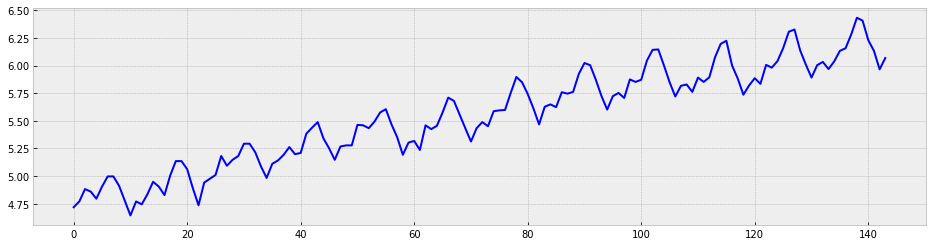

In [5]:
series = boxcox(airlines_passengers['Count'], 0)
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 4))
    plt.plot(series, color='blue')


# Дифференцируем 

In [6]:
import numpy as np

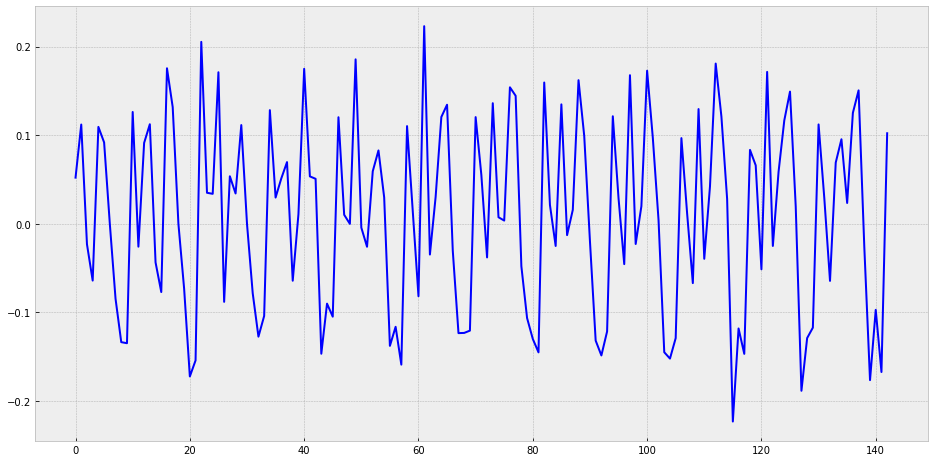

In [7]:
series = np.diff(series, 1)    
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(series, color='blue')

In [8]:
# Функция для расчета Скользящей средней
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()


# Функция для расчета Взвешенной Скользящей средней
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

# Функция для расчета Экспоненцтальной Скользящей средней
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [11]:
# Функция для расчета Двойной Экспоненцтальной Скользящей средней
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

def plot_dema(series, alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [14]:
# Функция для расчета Тройной Экспоненцтальной Скользящей средней

def initial_trend(series, season_len):
    return sum([float(series[season_len] - series[0]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser=airlines_passengers['Count'], ser_to_plot=airlines_passengers['Count'], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

### Оценим качество на нестационарном ряде

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize_scalar
from scipy.optimize import brute
from scipy.optimize import fmin

In [18]:
train, val = airlines_passengers['Count'][:120], airlines_passengers['Count'][120:]
train_stat, val_stat = series[:120], series[120:]

In [20]:
def ma_cross_val(X, ser):
    n = int(X)
    #print((n))
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(ser):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = moving_average(train_split_ts, n)
        nan_count = len(result[result.isna()==True])
        predictions = result[-len(test_split_ts):]
        #print(result)
        error = mean_squared_error(predictions[nan_count+1:], test_split_ts[nan_count+1:])
        errors.append(error)
    
    #print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [21]:
def wma_cross_val(X, ser):
    f, s = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(ser):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = weighted_moving_average(train_split_ts, 2, [f, s])
        nan_count = len(result[result.isna()==True])
        predictions = result[-len(test_split_ts):]
        #print(result)
        error = mean_squared_error(predictions[nan_count:], test_split_ts[nan_count:])
        errors.append(error)
    
    #print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [22]:
def ema_cross_val(X, ser):
    alpha = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(ser):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = exponential_moving_average(train_split_ts, alpha)
        #nan_count = len(result[result.isna()==True])
        predictions = result[-len(test_split_ts):]
        #print(result)
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    
    #print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [23]:
def dema_cross_val(X, ser):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(ser):
        
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = double_ema(train_split_ts, alpha, beta)
        #nan_count = len(result[result.isna()==True])
        #print(nan_count)
        predictions = result[-len(test_split_ts):]
        #print(result)
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    
    #print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [19]:
def tema_cross_val(X, ser):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(ser):

        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    # print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [45]:
R2 = []

# Рассчитаем качество на разных моделях скользящих средних на нестационаром и стационарном рядах

## Скользящая средняя

In [46]:

ma_opt = brute(ma_cross_val, (slice(1,13,1),), args=(train,), full_output=True, finish=None)
ma_opt
print(ma_opt[0])
## R2 score для трейновой выборки
ma_train = moving_average(train, int(ma_opt[0]))
nan_count = len(ma_train[ma_train.isna()==True])
print(f'ma_train r2_score: {r2_score(train[nan_count:], ma_train[nan_count:]):,.3f}')

ma_stat_train = moving_average(train_stat, int(ma_opt[0]))
print(f'ma_stat_train r2_score: {r2_score(train_stat[nan_count:],ma_stat_train[nan_count:]):,.3f}')

## R2 score для валидационной выборки
ma_val = moving_average(val, int(ma_opt[0]))
nan_count = len(ma_val[ma_val.isna()==True])
print(f'ma_val r2_score: {r2_score(val[nan_count:], ma_val[nan_count:]):,.3f}')

ma_stat = moving_average(val_stat, int(ma_opt[0]))
print(f'ma_stat_val r2_score: {r2_score(val_stat[nan_count:], ma_stat[nan_count:]):,.3f}')

R2.append((r2_score(train[nan_count:], ma_train[nan_count:]),
          r2_score(train_stat[nan_count:],ma_stat_train[nan_count:]),
          r2_score(val[nan_count:], ma_val[nan_count:]),
          r2_score(val_stat[nan_count:], ma_stat[nan_count:])))

2.0
ma_train r2_score: 0.977
ma_stat_train r2_score: 0.593
ma_val r2_score: 0.872
ma_stat_val r2_score: 0.643


## Взвешенная скользящая средняя

In [68]:

wma_opt = brute(wma_cross_val, (slice(1,20,1), slice(1,20,1)), args=(train,), full_output=True, finish=None)
print(wma_opt[0])

wma_stat_opt = brute(wma_cross_val, (slice(1,20,1), slice(1,20,1)), args=(train_stat,), full_output=True, finish=None)
print(wma_stat_opt[0])

## R2 score для трейновой выборки
wma_train = weighted_moving_average(train, 2, [*wma_opt[0]])
nan_count = len(wma_train[wma_train.isna()==True])
print(f'wma_train r2_score: {r2_score(train[nan_count:], wma_train[nan_count:]):,.3f}')
wma_stat_train = weighted_moving_average(train_stat, 2, [*wma_opt[0]])
nan_count = len(wma_stat_train[wma_stat_train.isna()==True])
print(f'wma_stat_train r2_score: {r2_score(train_stat[nan_count:], wma_stat_train[nan_count:]):,.3f}')

## R2 score для валидационной выборки
wma_val = weighted_moving_average(val, 2, [*wma_opt[0]])
nan_count = len(wma_val[wma_val.isna()==True])
print(f'wma_val r2_score: {r2_score(val[nan_count:], wma_val[nan_count:]):,.3f}')
wma_stat = weighted_moving_average(val_stat, 2, [*wma_opt[0]])
print(f'wma_stat_val r2_score: {r2_score(val_stat[nan_count:], wma_stat[nan_count:]):,.3f}')

R2.append((r2_score(train[nan_count:], wma_train[nan_count:]),
          r2_score(train_stat[nan_count:],wma_stat_train[nan_count:]),
          r2_score(val[nan_count:], wma_val[nan_count:]),
          r2_score(val_stat[nan_count:], wma_stat[nan_count:])))

[ 1. 19.]
[ 1. 19.]
wma_train r2_score: 1.000
wma_stat_train r2_score: 0.996
wma_val r2_score: 0.999
wma_stat_val r2_score: 0.996


## Экспоненциальная скользящая средняя

In [48]:
ema_opt = minimize(ema_cross_val, x0=[0], args=(train,), method="Nelder-Mead")
print(ema_opt.x)
ema_stat_opt = minimize(ema_cross_val, x0=[0], args=(train_stat,), method="Nelder-Mead")
print(ema_stat_opt.x)

## R2 score для трейновой выборки
ema_train = exponential_moving_average(train, *ema_opt.x)
print(f'ema_train r2_score: {r2_score(train, ema_train):,.3f}')
ema_stat_train = exponential_moving_average(train_stat, *ema_stat_opt.x)
print(f'ema_stat_train r2_score: {r2_score(train_stat, ema_stat_train):,.3f}')

## R2 score для валидационной выборки
ema_val = exponential_moving_average(val.reset_index(drop=True), *ema_opt.x)
print(f'ema_val r2_score: {r2_score(val, ema_val):,.3f}')
ema_stat_val = exponential_moving_average(val_stat, *ema_stat_opt.x)
print(f'ema_stat_val r2_score: {r2_score(val_stat, ema_stat_val):,.3f}')

R2.append((r2_score(train, ema_train),
          r2_score(train_stat,ema_stat_train),
          r2_score(val, ema_val),
          r2_score(val_stat, ema_stat_val)))

[0.34425]
[0.34425]
ema_train r2_score: 0.931
ema_stat_train r2_score: 0.465
ema_val r2_score: 0.618
ema_stat_val r2_score: 0.472


## Двойная Экспоненциальная скользящая средняя

In [83]:
dema_opt = minimize(dema_cross_val, x0=[0, 0], args=(train,), method="Nelder-Mead")
#dema_opt = brute(dema_cross_val, (slice(0, 1, 0.01), slice(0, 1, 0.01)), args=(train,), full_output=True, finish=fmin)
print(dema_opt.x)

dema_stat_opt = minimize(dema_cross_val, x0=[0, 0], args=(train_stat,), method="Nelder-Mead")
print(dema_stat_opt.x)

## R2 score для трейновой выборки
dema_train = double_ema(train, *dema_opt.x)
print(f'dema_train r2_score: {r2_score(train, dema_train):,.3f}')
dema_stat_train = double_ema(train_stat, *dema_stat_opt.x)
print(f'dema_stat_train r2_score: {r2_score(train_stat, dema_stat_train):,.3f}')

## R2 score для валидационной выборки
dema_val = double_ema(val.to_list(), *dema_opt.x)
print(f'dema_val r2_score: {r2_score(val, dema_val):,.3f}')
dema_stat_val = double_ema(val_stat, *dema_stat_opt.x)
print(f'dema_stat_val r2_score: {r2_score(val_stat, dema_stat_val):,.3f}')

R2.append((r2_score(train, dema_train),
          r2_score(train_stat,dema_stat_train),
          r2_score(val, dema_val),
          r2_score(val_stat, dema_stat_val)))

[ 0.04416498 -0.00268838]
[ 0.04416498 -0.00268838]
dema_train r2_score: 0.144
dema_stat_train r2_score: -150.766
dema_val r2_score: -10.264
dema_stat_val r2_score: -378.227


## Тройная Экспоненциальная скользящая средняя

In [50]:
tema_opt = minimize(tema_cross_val, x0=[0, 0, 0], args=(train,), method="Nelder-Mead")
print(tema_opt.x)
tema_stat_opt = minimize(tema_cross_val, x0=[0, 0, 0], args=(train_stat,), method="Nelder-Mead")
print(tema_stat_opt.x)

## R2 score для трейновой выборки
tema_train = triple_exponential_smoothing(train, 12, *tema_opt.x, n_preds=0)
print(f'tema_train r2_score: {r2_score(train, tema_train):,.3f}')
tema_stat_train = triple_exponential_smoothing(train_stat, 12, *tema_stat_opt.x, n_preds=0)
print(f'tema_stat_train r2_score: {r2_score(train_stat, tema_stat_train):,.3f}')


## R2 score для валидационной выборки
tema_val = triple_exponential_smoothing(val.to_list(), 12, *tema_opt.x, n_preds=0)
print(f'tema_val r2_score: {r2_score(val, tema_val):,.3f}')
tema_stat_val = triple_exponential_smoothing(val_stat, 12, *tema_stat_opt.x, n_preds=0)
print(f'tema_stat_val r2_score: {r2_score(val_stat, tema_stat_val):,.3f}')

R2.append((r2_score(train, tema_train),
          r2_score(train_stat,tema_stat_train),
          r2_score(val, tema_val),
          r2_score(val_stat, tema_stat_val)))

[0.02722178 0.32635344 1.44178296]
[0.02722178 0.32635344 1.44178296]
tema_train r2_score: 0.991
tema_stat_train r2_score: 0.931
tema_val r2_score: 0.929
tema_stat_val r2_score: 0.936


In [62]:
pd.DataFrame(list(zip(*R2)), index=['train', 'train_stat', 'val', 'val_stat'], 
             columns=['MA', 'WMA', 'EMA', 'DEMA', 'TEMA']).round(3)

,MA,WMA,EMA,DEMA,TEMA
train,0.977,1.000,0.931,0.144,0.991
train_stat,0.593,0.996,0.465,-150.766,0.931
val,0.872,0.999,0.618,-10.264,0.929
val_stat,0.643,0.996,0.472,-378.227,0.936


#### Лучше всего приближают ряды WMA (за счет высокой чувствительности к изменениям) и TEMA (за счет за счет высокой чувствительности к изменениям и учета тренда и сезонности)
#### Качество DEMA низкое, по причине того, что не учитывается сезонность 

### Построим Скользящие средние для нестационарного и стационарного рядов

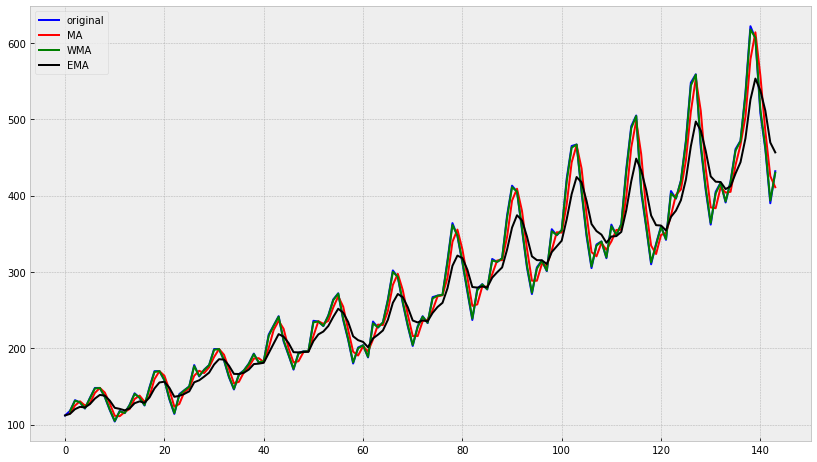

In [66]:
# Скользящие средние для нестационаргого ряда
ema = exponential_moving_average(airlines_passengers['Count'], ema_opt.x)
wma = weighted_moving_average(airlines_passengers['Count'], 2, [*wma_opt[0]])
ma = moving_average(airlines_passengers['Count'], 2)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers['Count'], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

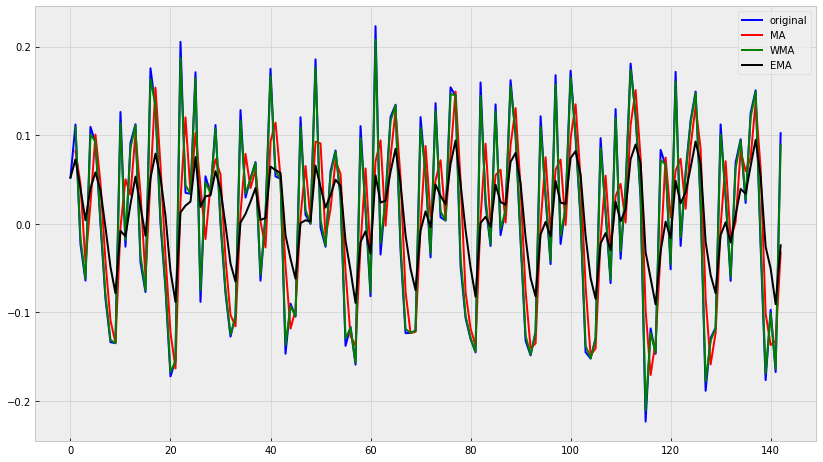

In [69]:
# Скользящие средние для стационаргого ряда
ema = exponential_moving_average(series, ema_stat_opt.x)
wma = weighted_moving_average(series, 2, [*wma_stat_opt[0]])
ma = moving_average(series, 2)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

### Построим Двойное экспоненциальное сглаживание

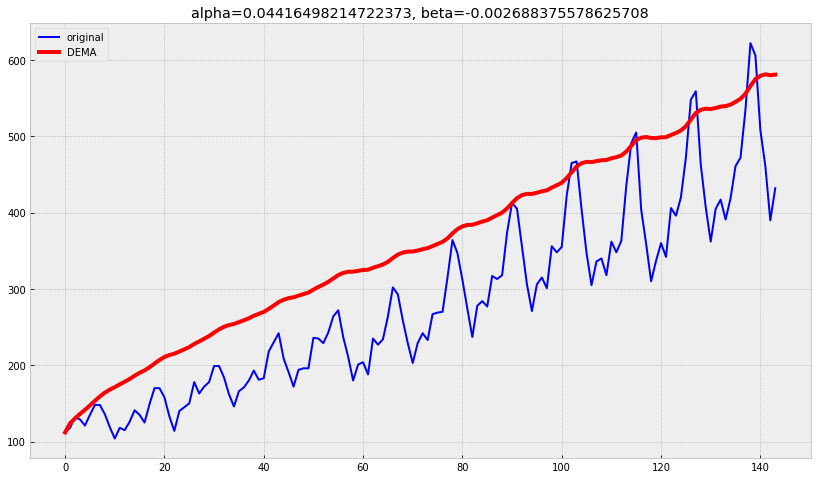

In [89]:
plot_dema(airlines_passengers['Count'], *dema_opt.x)

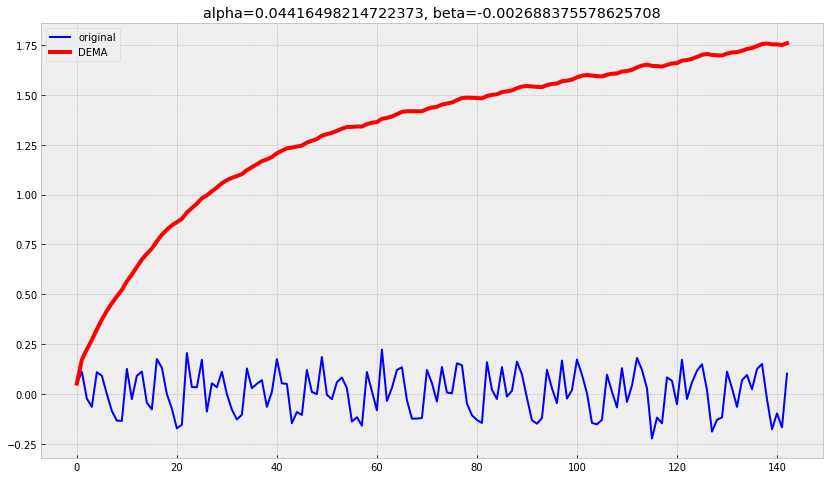

In [74]:
plot_dema(series, *dema_stat_opt.x)

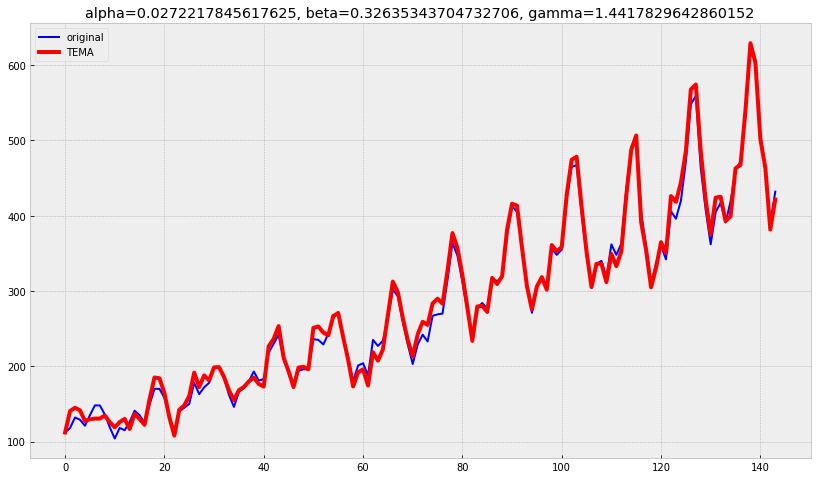

In [75]:
plot_tema(*tema_opt.x, n_preds=0)

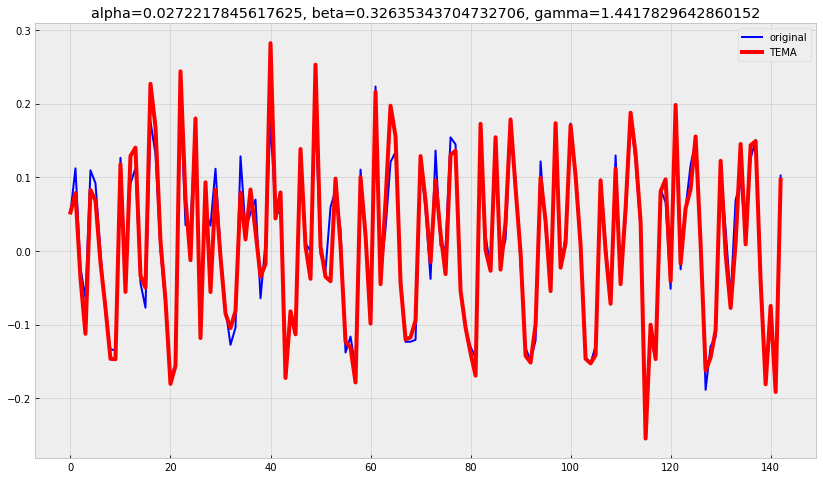

In [76]:
plot_tema(*tema_stat_opt.x, series, series, n_preds=0)